In [ ]:
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
from matplotlib import pyplot as plt

PI = np.pi

# Demonstrate fitting a model to data

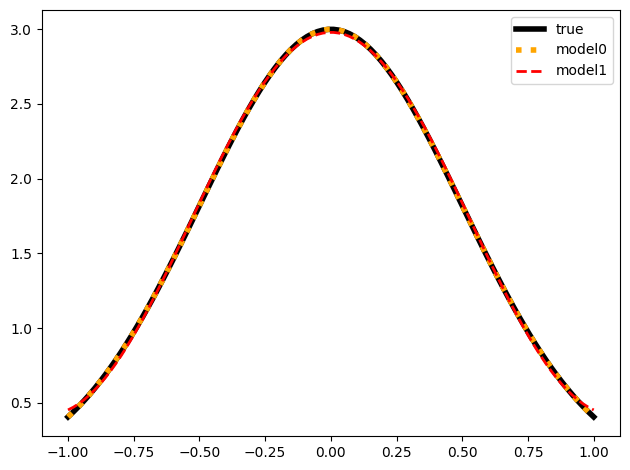

In [ ]:
def true(x):
    return 3 * np.exp(-2 * x**2)


def model0(x, a, b):
    return a * np.exp(-b * x**2)


def model1(t, a, b, c, d, e):
    return a * np.exp(b * t) + c * np.sin(d * t - e)


xls = np.linspace(-1, 1, 100)
y = true(xls)

params0, _ = curve_fit(model0, xls, y)
params1, _ = curve_fit(model1, xls, y)

plt.plot(xls, y, label="true", lw=4, color="black")
plt.plot(
    xls, model0(xls, *params0), label="model0", ls=":", color="orange", lw=4
)
plt.plot(xls, model1(xls, *params1), label="model1", ls="--", color="red", lw=2)
plt.legend()
plt.tight_layout()
plt.show()

# Fit model to data

## Aggregate housing data by month

Compute price per square foot, then take average for each month.

In [ ]:
filepath = "nyc-property-sales-cleaned.csv"

df = pd.read_csv(filepath, parse_dates=["SALE DATE"])
df["YEAR BUILT"] = pd.to_datetime(df["YEAR BUILT"], format="%Y")

df = df.drop(["NEIGHBORHOOD", "ADDRESS"], axis=1)

In [ ]:
df["price_per_land_sq_ft"] = df["SALE PRICE"] / df["LAND SQUARE FEET"]
df["price_per_gross_sq_ft"] = df["SALE PRICE"] / df["GROSS SQUARE FEET"]

In [ ]:
grouped = df.groupby(pd.Grouper(key="SALE DATE", freq="ME"))
means = grouped.mean()

land, gross = means["price_per_land_sq_ft"], means["price_per_gross_sq_ft"]
datasets = {"land": land, "gross": gross}

means

,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,price_per_land_sq_ft,price_per_gross_sq_ft
SALE DATE,,,,,,
2018-01-31,2811.871951,1695.426829,1998-02-12 05:07:19.024390272,685214.091463,326.876688,374.715699
2018-02-28,2797.036232,1732.550725,2000-10-26 10:15:39.130434816,650597.760870,306.656582,373.854224
2018-03-31,2926.098039,1759.764706,2000-02-18 03:08:14.117647104,602562.869281,257.935402,338.368969
2018-04-30,2687.484472,1697.204969,1997-12-25 02:14:09.689441024,594740.906832,296.220016,342.973897
2018-05-31,2718.956790,1675.512346,1997-10-13 23:42:13.333333376,585146.814815,286.650988,339.981770
...,...,...,...,...,...,...
2023-07-31,2606.571429,1841.647619,1999-03-08 05:29:08.571428608,881733.647619,440.204853,451.299919
2023-08-31,3038.734375,1734.539062,1997-11-04 19:18:45.000000000,800452.906250,345.625814,453.075644
2023-09-30,2950.067961,1885.718447,1995-12-21 17:14:33.786407808,887932.310680,417.067883,446.056076


## Fit model

In [ ]:
def plot(name):
    data = datasets[name]

    tls = np.arange(len(data))

    fig, ax = plt.subplots(1, 1)

    ax.plot(tls, data, color="C0", label="true")

    ax.set_xlabel("month")
    ax.set_ylabel(rf" \$ / ft$^2$ ({name})")

    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks(tls[::12])
    ax2.set_xticklabels((tls[::12] / 12).astype(int))
    ax2.set_xlabel("year")

    ax.set_title(rf" \$ / ft$^2$ ({name})")
    fig.tight_layout()

    return fig, ax


def model(t, z, a1, a2, b1, b2, b3, b4):
    return (
        z
        + a1 * np.exp(a2 * t / 12)
        + b1 * np.sin(b2 * 2 * PI / 12 * t + b3) * np.exp(b4 * t / 12)
    )

### Gross

Below, `monthly_ratios` contains the average monthly percent change in the price per square foot (gross) over the ~6 years of data

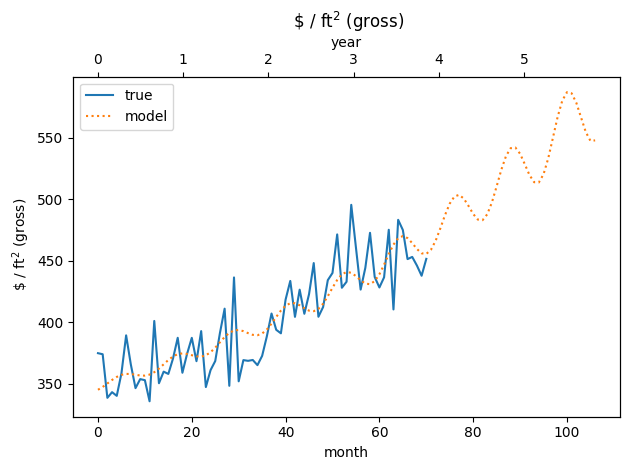

In [ ]:
name = "gross"

data = datasets[name]
tls = np.arange(len(data))

params, pcov = curve_fit(model, tls, data)

fig, ax = plot(name)
years = 3
tls = np.arange(len(data) + years * 12)
ax.plot(tls, model(tls, *params), label="model", color="C1", ls=":")

ax.legend()
fig.tight_layout()
plt.show()

In [ ]:
np.round(params, 2), np.round(pcov, 2)

f = lambda t: model(t, *params)
tls = np.arange(len(data) + 1)

ratios = f(tls + 1) / f(tls)
reshaped = ratios.reshape(-1, 12)
monthly_ratios = reshaped.mean(axis=0)

reshaped[:, 0], monthly_ratios

(array([1.00668749, 1.00813423, 1.00990657, 1.01206762, 1.01468779,
        1.01784396]),
 array([1.01155461, 1.01312199, 1.01224891, 1.00916218, 1.0046709 ,
        0.99994033, 0.99622244, 0.99457716, 0.99559717, 0.99917971,
        1.00444832, 1.00993749]))

### Land

Below, `monthly_ratios` contains the average monthly percent change in the price per square foot (land) over the ~6 years of data

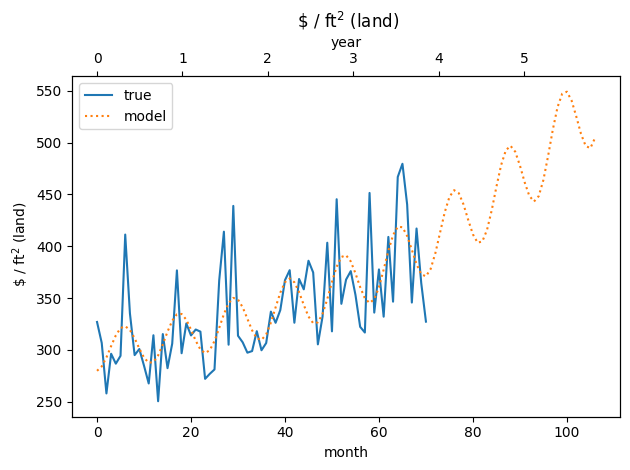

In [ ]:
name = "land"

data = datasets[name]
tls = np.arange(len(data))

params, pcov = curve_fit(model, tls, data)

fig, ax = plot(name)
years = 3
tls = np.arange(len(data) + years * 12)
ax.plot(tls, model(tls, *params), label="model", color="C1", ls=":")

ax.legend()
fig.tight_layout()
plt.show()

In [ ]:
np.round(params, 2), np.round(pcov, 2)

f = lambda t: model(t, *params)
tls = np.arange(len(data) + 1)

ratios = f(tls + 1) / f(tls)
reshaped = ratios.reshape(-1, 12)
monthly_ratios = reshaped.mean(axis=0)

reshaped[:, 0], monthly_ratios

(array([1.01516355, 1.02220729, 1.02933196, 1.03613134, 1.04217074,
        1.0470396 ]),
 array([1.03200741, 1.04138527, 1.03982343, 1.02866477, 1.01152415,
        0.99283269, 0.9770066 , 0.9680219 , 0.96883073, 0.98025495,
        0.99974694, 1.02134888]))